Transfer Learning through VGG16 and Resnet18


Importing the modules

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


plt.ion()   

Downloading the Data

In [2]:
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet.git

Cloning into 'Brain-Tumor-Classification-DataSet'...
remote: Enumerating objects: 3039, done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3039
Receiving objects: 100% (3039/3039), 79.25 MiB | 25.08 MiB/s, done.


Loading and Data Transformation

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'Training': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'Brain-Tumor-Classification-DataSet'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Training', 'Testing']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['Training', 'Testing']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}
class_names = image_datasets['Training'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training

In [31]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    label_list = []
    pred_list = []
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Testing']:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Training':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
            if phase == 'Training':
                print(epoch_loss)
                train_loss_list += [epoch_loss]
                print(train_loss_list)
                train_acc_list += [epoch_acc]
            else:
                val_loss_list += [epoch_loss]
                val_acc_list += [epoch_acc]

            # deep copy the model
            if phase == 'Testing' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_list, train_acc_list, val_loss_list, val_acc_list

Visualization

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Testing']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Model Evaluation

In [7]:
def get_predictions(model, iterator, device):
    labels = []
    probs = []
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(iterator):
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            _, y_preds = torch.max(outputs, 1)
            # y_pred, _ = model(x)
            labels += [y]
            probs += [y_preds]
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    return labels, probs

VGG16

In [40]:
# ---------- VGG16
model_ft = models.vgg16(pretrained=True)

n_inputs = model_ft.classifier[6].in_features

model_ft.classifier[6] = nn.Sequential(
      nn.Linear(in_features=n_inputs, out_features=256),
      nn.ReLU(),
      nn.Dropout(p=0.5,inplace=False),
      nn.Linear(256,4), # Output Dimension is 4
      nn.LogSoftmax(dim=1)
      )

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and Evaluate

In [41]:
model_ft, model_tr_loss, model_tr_acc, model_val_loss, model_val_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training Loss: 0.9445 Acc: 0.6073
0.944498771201261
[0.944498771201261]
Testing Loss: 0.9221 Acc: 0.6726

Epoch 1/24
----------
Training Loss: 0.6492 Acc: 0.7617
0.6491988403721022
[0.944498771201261, 0.6491988403721022]
Testing Loss: 0.9872 Acc: 0.6523

Epoch 2/24
----------
Training Loss: 0.4956 Acc: 0.8202
0.4955560640842842
[0.944498771201261, 0.6491988403721022, 0.4955560640842842]
Testing Loss: 1.4629 Acc: 0.6980

Epoch 3/24
----------
Training Loss: 0.4066 Acc: 0.8537
0.406631625266194
[0.944498771201261, 0.6491988403721022, 0.4955560640842842, 0.406631625266194]
Testing Loss: 0.9239 Acc: 0.7335

Epoch 4/24
----------
Training Loss: 0.4138 Acc: 0.8561
0.41377493517407626
[0.944498771201261, 0.6491988403721022, 0.4955560640842842, 0.406631625266194, 0.41377493517407626]
Testing Loss: 1.0286 Acc: 0.6980

Epoch 5/24
----------
Training Loss: 0.3354 Acc: 0.8756
0.33543253978910825
[0.944498771201261, 0.6491988403721022, 0.4955560640842842, 0.406631625266194, 0.41377493517407626, 0.3

In [42]:
labels, probs = get_predictions(model_ft, dataloaders['Testing'], device)
labels = labels.cpu().numpy()
probs = probs.cpu().numpy()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Visualizing the Model Loss

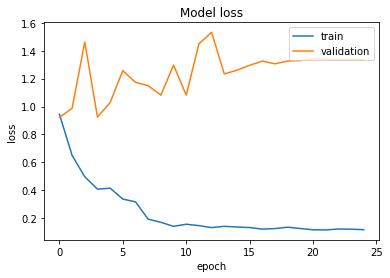

In [43]:
# ------------ Plot loss and Acc curves
plt.plot(model_tr_loss, label = 'train')
plt.plot(model_val_loss, label = 'validation')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

Visualizing the Model Accuracy

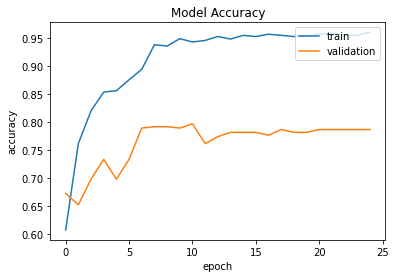

In [44]:
# ------------ Plot loss and Acc curves
plt.plot(model_tr_acc, label = 'train')
plt.plot(model_val_acc, label = 'validation')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

Confusion Matrix

In [45]:
def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

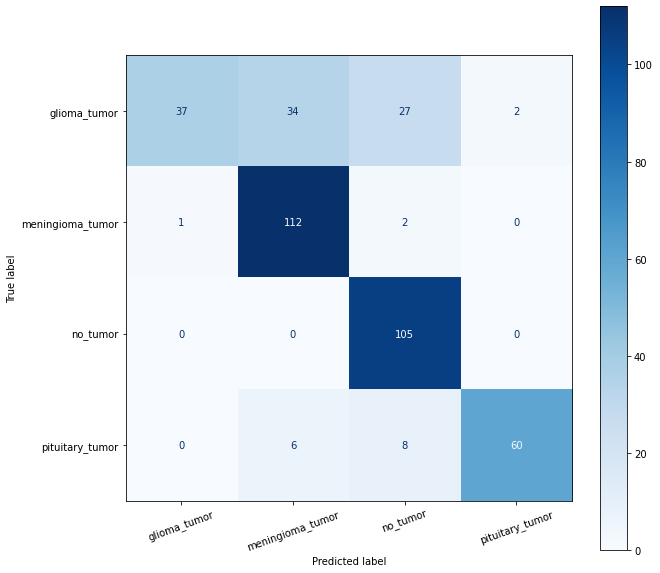

In [46]:
plot_confusion_matrix(labels, probs, class_names)

Resnet18

In [36]:
# --------- resnet 18 with SGD

model_ft_vnet_s = models.resnet18(pretrained=True)

# for param in model_ft_vnet_s.parameters():
#     param.requires_grad = False

num_ftrs = model_ft_vnet_s.fc.in_features

# Here the size of each output sample is set to 4.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft_vnet_s.fc = nn.Linear(num_ftrs, 4)

model_ft_vnet_s = model_ft_vnet_s.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_vnet_s = optim.SGD(model_ft_vnet_s.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_vnet_s = lr_scheduler.StepLR(optimizer_ft_vnet_s, step_size=7, gamma=0.1)


model_ft_vnet_s, model_tr_loss_v, model_tr_acc_v, model_val_loss_v, model_val_acc_v = train_model(model_ft_vnet_s, criterion, optimizer_ft_vnet_s, exp_lr_scheduler_vnet_s,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training Loss: 0.9708 Acc: 0.6328
0.9707503869039257
[0.9707503869039257]
Testing Loss: 1.3075 Acc: 0.6320

Epoch 1/24
----------
Training Loss: 0.6962 Acc: 0.7460
0.6962192205932861
[0.9707503869039257, 0.6962192205932861]
Testing Loss: 1.6528 Acc: 0.6878

Epoch 2/24
----------
Training Loss: 0.7015 Acc: 0.7596
0.7015329129448751
[0.9707503869039257, 0.6962192205932861, 0.7015329129448751]
Testing Loss: 1.7269 Acc: 0.6675

Epoch 3/24
----------
Training Loss: 0.5425 Acc: 0.8010
0.5424775899566372
[0.9707503869039257, 0.6962192205932861, 0.7015329129448751, 0.5424775899566372]
Testing Loss: 1.2081 Acc: 0.7386

Epoch 4/24
----------
Training Loss: 0.4660 Acc: 0.8338
0.46601093209442723
[0.9707503869039257, 0.6962192205932861, 0.7015329129448751, 0.5424775899566372, 0.46601093209442723]
Testing Loss: 1.9522 Acc: 0.6853

Epoch 5/24
----------
Training Loss: 0.4909 Acc: 0.8317
0.49091712219465383
[0.9707503869039257, 0.6962192205932861, 0.7015329129448751, 0.5424775899566372, 0.46601093209

Visualizing the Model Loss

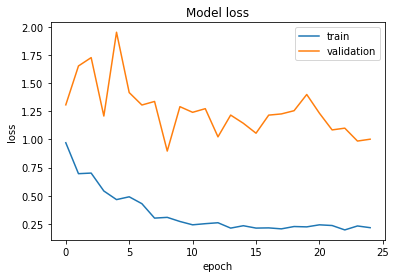

In [37]:
# ------------ Plot loss and Acc curves
plt.plot(model_tr_loss_v, label = 'train')
plt.plot(model_val_loss_v, label = 'validation')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

Visualizing the Model Accuracy

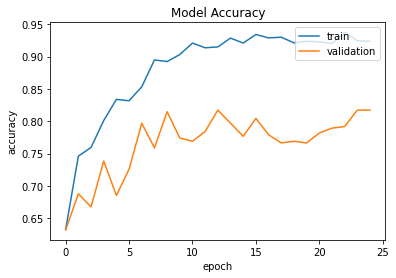

In [38]:
# ------------ Plot loss and Acc curves
plt.plot(model_tr_acc_v, label = 'train')
plt.plot(model_val_acc_v, label = 'validation')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

Confusion Matrix

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


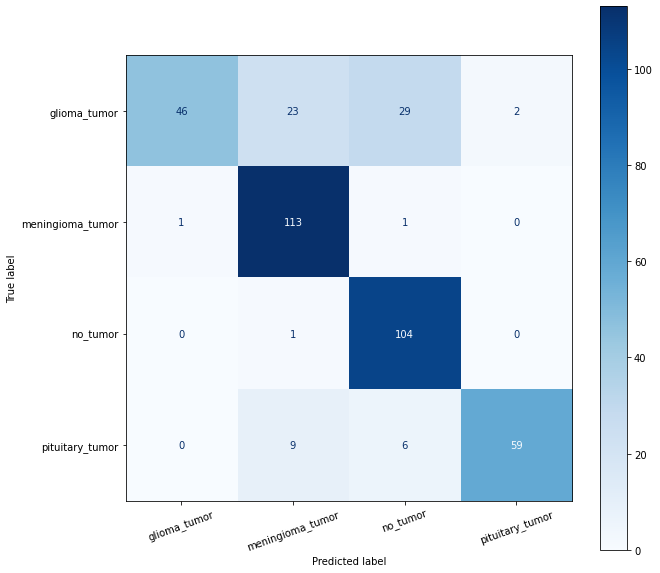

In [39]:
labels_v, probs_v = get_predictions(model_ft_vnet_s, dataloaders['Testing'], device)
labels_v = labels_v.cpu().numpy()
probs_v = probs_v.cpu().numpy()
plot_confusion_matrix(labels_v, probs_v, class_names)